In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Stickyfy'
assert FOLDERNAME is not None, "[!] Enter the foldername."

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.models as model
import os
from PIL import Image
from matplotlib import image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import cv2
import h5py
%matplotlib inline
dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0")

In [3]:
# Functions to pre process cartoon image
def remove_alpha(image, bg_color = (255,255,255)):
  if image.mode == 'RGBA':
    alpha = image.split()[-1]
    bg = Image.new("RGB", image.size, bg_color + (255,))
    bg.paste(image, mask=alpha)
    return bg
  else:
    return image
    
def preprocess(image):
  img_with_bg = remove_alpha(image)
  res_img = img_with_bg.resize((128,128))
  return res_img

class custom(object):
  def __call__(self, image):
    return remove_alpha(image)

In [4]:
class dataset_h5(torch.utils.data.Dataset):
  def __init__(self, in_file, transforms):
    super(dataset_h5, self).__init__()
    self.file = h5py.File(in_file, 'r')
    self.transform = transforms
    self.n_images = len((self.file).keys())

  def __getitem__(self, index):
      input = self.file['X'+str(index)][:,:,:]
      input = Image.fromarray(input)
      input = self.transform(input)
      return input

  def __len__(self):
      return self.n_images

In [5]:
img_transforms = transforms.Compose([
                                       custom(),
                                       transforms.Resize(32),
                                       transforms.ToTensor(),
])
cartoon_file = '/content/drive/My Drive/Stickyfy/cartoon_data.h5'
cartoon_dataset_h5 = dataset_h5(cartoon_file, img_transforms)
cartoon_loader = torch.utils.data.DataLoader(cartoon_dataset_h5, shuffle = True, batch_size = 256)
face_file = '/content/drive/My Drive/Stickyfy/face_data.h5'
face_dataset_h5 = dataset_h5(face_file, img_transforms)
face_loader = torch.utils.data.DataLoader(face_dataset_h5, shuffle = True, batch_size = 512)

In [6]:
class Unflatten(nn.Module):
  def __init__(self,N,C,H,W):
    super(Unflatten, self).__init__()
    self.N = N
    self.W = W
    self.H = H
    self.C = C
  def forward(self,X):
    return X.view(self.N, self.C, self.H, self.W)


class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()
  def forward(self, x):
    N = x.shape[0]
    return x.view(N,-1)

def initialize_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
    nn.init.xavier_uniform_(m.weight.data)

In [18]:
resnet18 = model.resnet18()
modules=list(resnet18.children())[:-1]
resnet18 = nn.Sequential(
    *modules,
    Flatten(),
    nn.Linear(512, 1)
)
initialize_weights(resnet18)
resnet18.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [25]:
def square_loss(scores, y):
  loss = 0.5 * torch.sum(torch.square(scores - y))
  return loss

def train_resnet(face_loader, cartoon_loader, model, num_epoch = 50, print_every = 10):
  optimizer = optim.Adam(model.parameters(), lr = 0.0001)
  losses = []
  for i in np.arange(num_epoch):
    face_iter = iter(face_loader)
    cartoon_iter = iter(cartoon_loader)
    count = 0
    sum_loss = 0.0
    while True:
      try:
        fbatch = face_iter.next()
        cbatch = cartoon_iter.next()
      except StopIteration:
        if i%print_every == print_every-1:
          print("Epoch :- {}, loss = {}".format(i+1, sum_loss/count))
        losses.append(sum_loss/count)
        break
      except Exception as e:
        continue
      fbatch = fbatch.type(dtype)
      cbatch = cbatch.type(dtype)
      count+=1
      scores_f = model(fbatch)
      target2 = torch.zeros(scores_f.shape).type(dtype)
      target2.requires_grad = True
      scores_c = model(cbatch)
      target1 = torch.ones(scores_c.shape).type(dtype)
      target1.requires_grad = True
      loss = square_loss(scores_f, target2) + square_loss(scores_c, target1)
      model.zero_grad()
      loss.backward()
      optimizer.step()
      sum_loss += loss
  return losses

In [27]:
loss = train_resnet(face_loader, cartoon_loader, resnet18, 50,1)

Epoch :- 1, loss = 1.0625282526016235
Epoch :- 2, loss = 0.08978205174207687
Epoch :- 3, loss = 0.062236085534095764
Epoch :- 4, loss = 0.043951038271188736
Epoch :- 5, loss = 0.0470505952835083
Epoch :- 6, loss = 0.042707525193691254
Epoch :- 7, loss = 0.05346011370420456
Epoch :- 8, loss = 0.04374741017818451
Epoch :- 9, loss = 0.03770628571510315
Epoch :- 10, loss = 0.034377798438072205
Epoch :- 11, loss = 0.03311760351061821
Epoch :- 12, loss = 0.03891493380069733
Epoch :- 13, loss = 0.039528440684080124
Epoch :- 14, loss = 0.03909887373447418
Epoch :- 15, loss = 0.03707459196448326
Epoch :- 16, loss = 0.04489169642329216
Epoch :- 17, loss = 0.039908748120069504
Epoch :- 18, loss = 0.03555208072066307
Epoch :- 19, loss = 0.03533468022942543
Epoch :- 20, loss = 0.039374012500047684
Epoch :- 21, loss = 0.03190683573484421
Epoch :- 22, loss = 0.02323146164417267
Epoch :- 23, loss = 0.023688189685344696
Epoch :- 24, loss = 0.023584362119436264
Epoch :- 25, loss = 0.026668677106499672
E

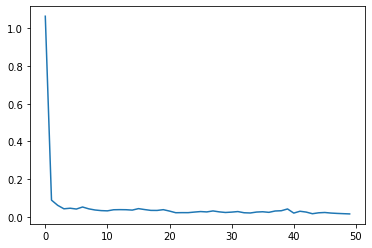

In [28]:
range = np.arange(50)
loss_t = []
for l in loss:
  loss_t.append(float(l.squeeze()))
plt.plot(range, loss_t)

In [29]:
path = '/content/drive/My Drive/Stickyfy/Models/'
torch.save(resnet18.state_dict(), path+'res_cartoon.pt')